In [230]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from rdflib import Graph
import matplotlib.pyplot as plt
from ampligraph.utils import save_model, restore_model
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans
from sklearn import metrics
%matplotlib inline

In [2]:
tf.test.is_gpu_available()

2023-12-15 20:42:04.889182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 20:42:04.895117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 20:42:04.895291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

True

In [3]:
g = Graph()
g.parse("../data/music_graph.ttl");

In [13]:
data = [triplet for triplet in g]
len(data)

795348

In [14]:
cols = ["subject", "predicate", "object"]
def remove_prefix(x):
    return re.sub(".+#", "", x)
triples_df = pd.DataFrame(data, columns=cols)
for c in cols:
    triples_df[c] = triples_df[c].apply(lambda x: str(x.toPython()))
    triples_df[c] = triples_df[c].apply(remove_prefix) 
triples_df

,subject,predicate,object
0,track_1EPNMdf6BfE4pMvGrL0TMV,popularity,20
1,track_06BlXCvoKvpvnH8WJ39pSs,performedBy,39T6qqI0jDtSWWioX8eGJz
2,track_4wv4mYGR4R1e3Scp3Ri1cf,performedBy,performer_74KPeP60dRLSAAk7sFtWTC
3,album_2256qKBSQdt53T5dz4Kdcs,type,Album
4,track_0i4tyixbYk32UpBsx1GFSa,performedBy,performer_1E4r4z7ivGUcSAnCbINJ9v
...,...,...,...
795343,track_3M8CUA40qXgzVIrpnGmosc,duration,273972
795344,track_0H9cBCGyUx2oA82M4ZAUmy,danceability,0.498
795345,album_6VBlasy358A35gHRnRY7HO,performedBy,performer_2N6aCxMw56t6OuH5Jn23D7
795346,track_0aOQBM8gVoV7d5kvety7iH,type,Track


In [22]:
columns = triples_df.columns
data_train, data_test = train_test_split_no_unseen(triples_df.values, test_size=0.2)
data_train = pd.DataFrame(data_train, columns=columns)
data_test = pd.DataFrame(data_test, columns=columns)
len(data_train), len(data_test)

(636279, 159069)

In [24]:
X_train, X_valid = train_test_split_no_unseen(data_train.values, test_size=10000)
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (626279, 3)
Test set size:  (10000, 3)


In [25]:
model = ScoringBasedEmbeddingModel(
    k=100, eta=1, scoring_type='TransE'
)

In [26]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

In [27]:
model.compile(
    optimizer=optim, loss=loss, entity_relation_regularizer=regularizer
)

In [28]:
# Fit the model
model.fit(
    X_train,
    batch_size=32768, # int(X_train.shape[0] / 50),
    epochs=250,  # Number of training epochs
    verbose=True  # Enable stdout messages
)

Epoch 1/250
21/21 [==============================] - 1s 58ms/step - loss: 21398.9414
Epoch 2/250
 6/21 [=======>......................] - ETA: 0s - loss: 21481.0254

2023-12-15 20:45:29.250182: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 21039.5742
Epoch 3/250
 6/21 [=======>......................] - ETA: 0s - loss: 21048.6895

2023-12-15 20:45:29.919766: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 20706.4629
Epoch 4/250
 6/21 [=======>......................] - ETA: 0s - loss: 20689.4824

2023-12-15 20:45:30.600915: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 20394.7246
Epoch 5/250
 6/21 [=======>......................] - ETA: 0s - loss: 20367.4258

2023-12-15 20:45:31.265320: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 20101.1484
Epoch 6/250
 6/21 [=======>......................] - ETA: 0s - loss: 20068.4375

2023-12-15 20:45:31.926844: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 19825.4668
Epoch 7/250
 6/21 [=======>......................] - ETA: 0s - loss: 19790.0371

2023-12-15 20:45:32.594481: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 19564.3535
Epoch 8/250
 4/21 [====>.........................] - ETA: 0s - loss: 19541.4219

2023-12-15 20:45:33.266816: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 19316.0195
Epoch 9/250
 6/21 [=======>......................] - ETA: 0s - loss: 19277.2520

2023-12-15 20:45:33.948409: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 32ms/step - loss: 19080.2578
Epoch 10/250
 4/21 [====>.........................] - ETA: 0s - loss: 19056.8750

2023-12-15 20:45:34.652721: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 32ms/step - loss: 18855.8613
Epoch 11/250
 6/21 [=======>......................] - ETA: 0s - loss: 18818.5098

2023-12-15 20:45:35.351287: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 18641.3008
Epoch 12/250
21/21 [==============================] - 1s 31ms/step - loss: 18434.6270
Epoch 13/250
 6/21 [=======>......................] - ETA: 0s - loss: 18398.2070

2023-12-15 20:45:36.742416: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 18236.4707
Epoch 14/250
 4/21 [====>.........................] - ETA: 0s - loss: 18214.7227

2023-12-15 20:45:37.409496: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 18045.4551
Epoch 15/250
 6/21 [=======>......................] - ETA: 0s - loss: 18009.6113

2023-12-15 20:45:38.101982: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 17860.4785
Epoch 16/250
 6/21 [=======>......................] - ETA: 0s - loss: 17825.8105

2023-12-15 20:45:38.756559: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 17681.3555
Epoch 17/250
 6/21 [=======>......................] - ETA: 0s - loss: 17647.3613

2023-12-15 20:45:39.418883: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 29ms/step - loss: 17508.5801
Epoch 18/250
 4/21 [====>.........................] - ETA: 0s - loss: 17488.1484

2023-12-15 20:45:40.063023: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 17339.7285
Epoch 19/250
 6/21 [=======>......................] - ETA: 0s - loss: 17306.5801

2023-12-15 20:45:40.741642: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 17175.2188
Epoch 20/250
 6/21 [=======>......................] - ETA: 0s - loss: 17142.5469

2023-12-15 20:45:41.419797: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 17015.3086
Epoch 21/250
 6/21 [=======>......................] - ETA: 0s - loss: 16983.0273

2023-12-15 20:45:42.094898: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 16859.0039
Epoch 22/250
 6/21 [=======>......................] - ETA: 0s - loss: 16827.2812

2023-12-15 20:45:42.778014: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 16706.0723
Epoch 23/250
 6/21 [=======>......................] - ETA: 0s - loss: 16674.8828

2023-12-15 20:45:43.447855: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 16556.3203
Epoch 24/250
 6/21 [=======>......................] - ETA: 0s - loss: 16525.6992

2023-12-15 20:45:44.133298: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 16410.0684
Epoch 25/250
 6/21 [=======>......................] - ETA: 0s - loss: 16379.5186

2023-12-15 20:45:44.780772: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 16266.0098
Epoch 26/250
 6/21 [=======>......................] - ETA: 0s - loss: 16235.9453

2023-12-15 20:45:45.436714: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 16125.1152
Epoch 27/250
 6/21 [=======>......................] - ETA: 0s - loss: 16095.2402

2023-12-15 20:45:46.097946: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 15986.1963
Epoch 28/250
 6/21 [=======>......................] - ETA: 0s - loss: 15956.6826

2023-12-15 20:45:46.746556: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 15849.5947
Epoch 29/250
 6/21 [=======>......................] - ETA: 0s - loss: 15820.4766

2023-12-15 20:45:47.426877: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 15715.1533
Epoch 30/250
 6/21 [=======>......................] - ETA: 0s - loss: 15686.0205

2023-12-15 20:45:48.103011: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 15582.4004
Epoch 31/250
 6/21 [=======>......................] - ETA: 0s - loss: 15553.8564

2023-12-15 20:45:48.768140: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 15451.8809
Epoch 32/250
 6/21 [=======>......................] - ETA: 0s - loss: 15423.3887

2023-12-15 20:45:49.437455: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 15322.6855
Epoch 33/250
 4/21 [====>.........................] - ETA: 0s - loss: 15305.7871

2023-12-15 20:45:50.118108: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 15195.1982
Epoch 34/250
 4/21 [====>.........................] - ETA: 0s - loss: 15178.4209

2023-12-15 20:45:50.800844: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 15069.0615
Epoch 35/250
 6/21 [=======>......................] - ETA: 0s - loss: 15041.2949

2023-12-15 20:45:51.482031: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 14944.3545
Epoch 36/250
 6/21 [=======>......................] - ETA: 0s - loss: 14916.6084

2023-12-15 20:45:52.155698: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 14821.2275
Epoch 37/250
 6/21 [=======>......................] - ETA: 0s - loss: 14793.9121

2023-12-15 20:45:52.827010: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 14699.9883
Epoch 38/250
 6/21 [=======>......................] - ETA: 0s - loss: 14672.7314

2023-12-15 20:45:53.509571: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 14579.8262
Epoch 39/250
 6/21 [=======>......................] - ETA: 0s - loss: 14552.8926

2023-12-15 20:45:54.178250: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 14461.2246
Epoch 40/250
 6/21 [=======>......................] - ETA: 0s - loss: 14434.5635

2023-12-15 20:45:54.853695: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 14344.0352
Epoch 41/250
 6/21 [=======>......................] - ETA: 0s - loss: 14317.6270

2023-12-15 20:45:55.526536: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 14228.0605
Epoch 42/250
 6/21 [=======>......................] - ETA: 0s - loss: 14201.8691

2023-12-15 20:45:56.202804: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 14113.4336
Epoch 43/250
 6/21 [=======>......................] - ETA: 0s - loss: 14087.1719

2023-12-15 20:45:56.878627: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 13999.7646
Epoch 44/250
 6/21 [=======>......................] - ETA: 0s - loss: 13973.9541

2023-12-15 20:45:57.547482: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 13887.6309
Epoch 45/250
 6/21 [=======>......................] - ETA: 0s - loss: 13861.9424

2023-12-15 20:45:58.219179: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 13776.7168
Epoch 46/250
 6/21 [=======>......................] - ETA: 0s - loss: 13751.3779

2023-12-15 20:45:58.885266: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 13667.3789
Epoch 47/250
 6/21 [=======>......................] - ETA: 0s - loss: 13642.2500

2023-12-15 20:45:59.561704: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 13559.5752
Epoch 48/250
 6/21 [=======>......................] - ETA: 0s - loss: 13534.9141

2023-12-15 20:46:00.231028: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 13453.2812
Epoch 49/250
 6/21 [=======>......................] - ETA: 0s - loss: 13428.6367

2023-12-15 20:46:00.903003: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 13347.8340
Epoch 50/250
 6/21 [=======>......................] - ETA: 0s - loss: 13323.5498

2023-12-15 20:46:01.569755: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 13243.8809
Epoch 51/250
 6/21 [=======>......................] - ETA: 0s - loss: 13219.8584

2023-12-15 20:46:02.246889: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 13141.3809
Epoch 52/250
 6/21 [=======>......................] - ETA: 0s - loss: 13117.6475

2023-12-15 20:46:02.912701: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 13040.1670
Epoch 53/250
 6/21 [=======>......................] - ETA: 0s - loss: 13016.8027

2023-12-15 20:46:03.581889: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 12940.6748
Epoch 54/250
 6/21 [=======>......................] - ETA: 0s - loss: 12917.5801

2023-12-15 20:46:04.249169: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 12842.4531
Epoch 55/250
 6/21 [=======>......................] - ETA: 0s - loss: 12819.5840

2023-12-15 20:46:04.923913: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 12745.4043
Epoch 56/250
 6/21 [=======>......................] - ETA: 0s - loss: 12722.8457

2023-12-15 20:46:05.597200: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 12649.6211
Epoch 57/250
 4/21 [====>.........................] - ETA: 0s - loss: 12636.2080

2023-12-15 20:46:06.277619: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 12555.0176
Epoch 58/250
 6/21 [=======>......................] - ETA: 0s - loss: 12532.9463

2023-12-15 20:46:06.957456: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 12461.8477
Epoch 59/250
 6/21 [=======>......................] - ETA: 0s - loss: 12440.1035

2023-12-15 20:46:07.625929: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 12370.0127
Epoch 60/250
 6/21 [=======>......................] - ETA: 0s - loss: 12348.5195

2023-12-15 20:46:08.298158: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 12279.4209
Epoch 61/250
 6/21 [=======>......................] - ETA: 0s - loss: 12258.2568

2023-12-15 20:46:08.964757: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 12190.0615
Epoch 62/250
 6/21 [=======>......................] - ETA: 0s - loss: 12169.0547

2023-12-15 20:46:09.632607: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 12101.6270
Epoch 63/250
 6/21 [=======>......................] - ETA: 0s - loss: 12080.9824

2023-12-15 20:46:10.309026: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 12014.5400
Epoch 64/250
 6/21 [=======>......................] - ETA: 0s - loss: 11994.0459

2023-12-15 20:46:10.980988: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 11928.4775
Epoch 65/250
 6/21 [=======>......................] - ETA: 0s - loss: 11908.3066

2023-12-15 20:46:11.657515: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 11843.5811
Epoch 66/250
 6/21 [=======>......................] - ETA: 0s - loss: 11823.5752

2023-12-15 20:46:12.324969: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 11759.7041
Epoch 67/250
 4/21 [====>.........................] - ETA: 0s - loss: 11747.8506

2023-12-15 20:46:12.997852: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 11676.9014
Epoch 68/250
 6/21 [=======>......................] - ETA: 0s - loss: 11657.4404

2023-12-15 20:46:13.683625: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 11595.2158
Epoch 69/250
 6/21 [=======>......................] - ETA: 0s - loss: 11575.9492

2023-12-15 20:46:14.361274: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 11514.5547
Epoch 70/250
 6/21 [=======>......................] - ETA: 0s - loss: 11495.4766

2023-12-15 20:46:15.029169: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 11434.8242
Epoch 71/250
 6/21 [=======>......................] - ETA: 0s - loss: 11415.9541

2023-12-15 20:46:15.705201: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 11355.9385
Epoch 72/250
 6/21 [=======>......................] - ETA: 0s - loss: 11337.2764

2023-12-15 20:46:16.384087: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 11278.0762
Epoch 73/250
 6/21 [=======>......................] - ETA: 0s - loss: 11259.7197

2023-12-15 20:46:17.047270: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 11201.4053
Epoch 74/250
 6/21 [=======>......................] - ETA: 0s - loss: 11183.1904

2023-12-15 20:46:17.716695: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 11125.6328
Epoch 75/250
 6/21 [=======>......................] - ETA: 0s - loss: 11107.6758

2023-12-15 20:46:18.388012: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 11050.8164
Epoch 76/250
 6/21 [=======>......................] - ETA: 0s - loss: 11033.0703

2023-12-15 20:46:19.058186: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10977.0049
Epoch 77/250
 6/21 [=======>......................] - ETA: 0s - loss: 10959.4443

2023-12-15 20:46:19.731060: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10904.0342
Epoch 78/250
 6/21 [=======>......................] - ETA: 0s - loss: 10886.7305

2023-12-15 20:46:20.402370: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10832.0088
Epoch 79/250
 6/21 [=======>......................] - ETA: 0s - loss: 10814.9639

2023-12-15 20:46:21.074671: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10760.9580
Epoch 80/250
 6/21 [=======>......................] - ETA: 0s - loss: 10744.0898

2023-12-15 20:46:21.750741: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10690.9414
Epoch 81/250
 4/21 [====>.........................] - ETA: 0s - loss: 10680.9844

2023-12-15 20:46:22.429779: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10621.8164
Epoch 82/250
 6/21 [=======>......................] - ETA: 0s - loss: 10605.3740

2023-12-15 20:46:23.119177: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10553.4736
Epoch 83/250
 6/21 [=======>......................] - ETA: 0s - loss: 10537.2559

2023-12-15 20:46:23.792815: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10486.0977
Epoch 84/250
 6/21 [=======>......................] - ETA: 0s - loss: 10470.0508

2023-12-15 20:46:24.463258: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10419.5664
Epoch 85/250
 6/21 [=======>......................] - ETA: 0s - loss: 10403.6982

2023-12-15 20:46:25.141267: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 32ms/step - loss: 10353.8838
Epoch 86/250
 6/21 [=======>......................] - ETA: 0s - loss: 10338.2676

2023-12-15 20:46:25.831216: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10289.1836
Epoch 87/250
 4/21 [====>.........................] - ETA: 0s - loss: 10279.9482

2023-12-15 20:46:26.509502: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10225.2520
Epoch 88/250
 6/21 [=======>......................] - ETA: 0s - loss: 10210.0146

2023-12-15 20:46:27.187683: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10162.0811
Epoch 89/250
 6/21 [=======>......................] - ETA: 0s - loss: 10147.0400

2023-12-15 20:46:27.867468: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10099.6973
Epoch 90/250
 6/21 [=======>......................] - ETA: 0s - loss: 10084.8018

2023-12-15 20:46:28.540985: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 10038.0088
Epoch 91/250
 6/21 [=======>......................] - ETA: 0s - loss: 10023.3164

2023-12-15 20:46:29.214378: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 9977.1025
Epoch 92/250
 6/21 [=======>......................] - ETA: 0s - loss: 9962.5625

2023-12-15 20:46:29.889932: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 9917.0020
Epoch 93/250
 6/21 [=======>......................] - ETA: 0s - loss: 9902.6348

2023-12-15 20:46:30.565302: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 9857.5996
Epoch 94/250
 6/21 [=======>......................] - ETA: 0s - loss: 9843.3584

2023-12-15 20:46:31.241208: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 9799.0205
Epoch 95/250
 6/21 [=======>......................] - ETA: 0s - loss: 9785.0205

2023-12-15 20:46:31.917930: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 33ms/step - loss: 9741.1738
Epoch 96/250
 4/21 [====>.........................] - ETA: 0s - loss: 9732.9131

2023-12-15 20:46:32.630319: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 9683.9971
Epoch 97/250
 6/21 [=======>......................] - ETA: 0s - loss: 9670.2334

2023-12-15 20:46:33.321302: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 9627.4180
Epoch 98/250
 6/21 [=======>......................] - ETA: 0s - loss: 9613.9180

2023-12-15 20:46:34.007092: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 9571.5410
Epoch 99/250
 4/21 [====>.........................] - ETA: 0s - loss: 9563.5146

2023-12-15 20:46:34.681624: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 9516.2734
Epoch 100/250
 4/21 [====>.........................] - ETA: 0s - loss: 9508.3730

2023-12-15 20:46:35.365136: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 9461.7539
Epoch 101/250
 6/21 [=======>......................] - ETA: 0s - loss: 9448.6738

2023-12-15 20:46:36.045929: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 9407.8115
Epoch 102/250
 6/21 [=======>......................] - ETA: 0s - loss: 9394.8896

2023-12-15 20:46:36.714184: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 9354.5889
Epoch 103/250
 4/21 [====>.........................] - ETA: 0s - loss: 9346.9844

2023-12-15 20:46:37.386387: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 32ms/step - loss: 9302.0625
Epoch 104/250
 6/21 [=======>......................] - ETA: 0s - loss: 9289.4199

2023-12-15 20:46:38.082775: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 9250.0420
Epoch 105/250
 6/21 [=======>......................] - ETA: 0s - loss: 9237.5459

2023-12-15 20:46:38.745251: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 9198.6758
Epoch 106/250
 4/21 [====>.........................] - ETA: 0s - loss: 9191.2930

2023-12-15 20:46:39.416055: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 9147.8818
Epoch 107/250
 4/21 [====>.........................] - ETA: 0s - loss: 9140.5957

2023-12-15 20:46:40.100312: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 32ms/step - loss: 9097.7920
Epoch 108/250
 6/21 [=======>......................] - ETA: 0s - loss: 9085.7627

2023-12-15 20:46:40.797986: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 9048.1846
Epoch 109/250
 4/21 [====>.........................] - ETA: 0s - loss: 9041.0225

2023-12-15 20:46:41.464793: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8999.0566
Epoch 110/250
 6/21 [=======>......................] - ETA: 0s - loss: 8987.2393

2023-12-15 20:46:42.144759: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8950.6152
Epoch 111/250
 6/21 [=======>......................] - ETA: 0s - loss: 8938.9980

2023-12-15 20:46:42.816810: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8902.6934
Epoch 112/250
 6/21 [=======>......................] - ETA: 0s - loss: 8891.1934

2023-12-15 20:46:43.499637: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8855.2373
Epoch 113/250
 6/21 [=======>......................] - ETA: 0s - loss: 8843.8662

2023-12-15 20:46:44.174778: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8808.3994
Epoch 114/250
 6/21 [=======>......................] - ETA: 0s - loss: 8797.1191

2023-12-15 20:46:44.842089: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8761.9961
Epoch 115/250
 6/21 [=======>......................] - ETA: 0s - loss: 8750.8428

2023-12-15 20:46:45.511827: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8716.0752
Epoch 116/250
 6/21 [=======>......................] - ETA: 0s - loss: 8705.0352

2023-12-15 20:46:46.191274: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8670.5820
Epoch 117/250
 6/21 [=======>......................] - ETA: 0s - loss: 8659.6572

2023-12-15 20:46:46.869326: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8625.7324
Epoch 118/250
 6/21 [=======>......................] - ETA: 0s - loss: 8614.8906

2023-12-15 20:46:47.546244: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8581.1924
Epoch 119/250
 6/21 [=======>......................] - ETA: 0s - loss: 8570.4492

2023-12-15 20:46:48.233006: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8537.1035
Epoch 120/250
 6/21 [=======>......................] - ETA: 0s - loss: 8526.5664

2023-12-15 20:46:48.917699: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8493.6514
Epoch 121/250
21/21 [==============================] - 1s 31ms/step - loss: 8450.6475
Epoch 122/250
 6/21 [=======>......................] - ETA: 0s - loss: 8440.2705

2023-12-15 20:46:50.276893: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8408.0742
Epoch 123/250
 6/21 [=======>......................] - ETA: 0s - loss: 8397.8389

2023-12-15 20:46:50.954317: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8366.0605
Epoch 124/250
 6/21 [=======>......................] - ETA: 0s - loss: 8355.9121

2023-12-15 20:46:51.623841: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8324.3906
Epoch 125/250
 6/21 [=======>......................] - ETA: 0s - loss: 8314.3408

2023-12-15 20:46:52.292178: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8283.1875
Epoch 126/250
 6/21 [=======>......................] - ETA: 0s - loss: 8273.2305

2023-12-15 20:46:52.962138: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8242.3711
Epoch 127/250
 6/21 [=======>......................] - ETA: 0s - loss: 8232.5723

2023-12-15 20:46:53.635145: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8202.0527
Epoch 128/250
 6/21 [=======>......................] - ETA: 0s - loss: 8192.3438

2023-12-15 20:46:54.308978: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 8162.2017
Epoch 129/250
 6/21 [=======>......................] - ETA: 0s - loss: 8152.5654

2023-12-15 20:46:54.974968: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8122.6660
Epoch 130/250
 6/21 [=======>......................] - ETA: 0s - loss: 8113.1343

2023-12-15 20:46:55.648545: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8083.5278
Epoch 131/250
 6/21 [=======>......................] - ETA: 0s - loss: 8074.0693

2023-12-15 20:46:56.326070: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 8044.7778
Epoch 132/250
 6/21 [=======>......................] - ETA: 0s - loss: 8035.4629

2023-12-15 20:46:57.004419: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 8006.5713
Epoch 133/250
 6/21 [=======>......................] - ETA: 0s - loss: 7997.3057

2023-12-15 20:46:57.677395: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7968.6411
Epoch 134/250
 6/21 [=======>......................] - ETA: 0s - loss: 7959.5000

2023-12-15 20:46:58.342416: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7931.1245
Epoch 135/250
 6/21 [=======>......................] - ETA: 0s - loss: 7922.0679

2023-12-15 20:46:59.016365: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7893.9409
Epoch 136/250
 6/21 [=======>......................] - ETA: 0s - loss: 7884.9692

2023-12-15 20:46:59.689744: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7857.1196
Epoch 137/250
 6/21 [=======>......................] - ETA: 0s - loss: 7848.2578

2023-12-15 20:47:00.361043: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7820.7261
Epoch 138/250
 4/21 [====>.........................] - ETA: 0s - loss: 7815.4712

2023-12-15 20:47:01.033226: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7784.6860
Epoch 139/250
 6/21 [=======>......................] - ETA: 0s - loss: 7775.9644

2023-12-15 20:47:01.720590: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7748.8755
Epoch 140/250
 6/21 [=======>......................] - ETA: 0s - loss: 7740.2612

2023-12-15 20:47:02.390066: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7713.5352
Epoch 141/250
 6/21 [=======>......................] - ETA: 0s - loss: 7705.0132

2023-12-15 20:47:03.067403: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7678.5396
Epoch 142/250
 6/21 [=======>......................] - ETA: 0s - loss: 7670.0713

2023-12-15 20:47:03.737866: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7643.8413
Epoch 143/250
 6/21 [=======>......................] - ETA: 0s - loss: 7635.4761

2023-12-15 20:47:04.417726: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7609.5015
Epoch 144/250
 6/21 [=======>......................] - ETA: 0s - loss: 7601.2104

2023-12-15 20:47:05.091336: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7575.4609
Epoch 145/250
 6/21 [=======>......................] - ETA: 0s - loss: 7567.2075

2023-12-15 20:47:05.763009: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 7541.8062
Epoch 146/250
 6/21 [=======>......................] - ETA: 0s - loss: 7533.6826

2023-12-15 20:47:06.424335: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7508.5356
Epoch 147/250
 6/21 [=======>......................] - ETA: 0s - loss: 7500.4766

2023-12-15 20:47:07.096166: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7475.5464
Epoch 148/250
 6/21 [=======>......................] - ETA: 0s - loss: 7467.6060

2023-12-15 20:47:07.764626: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7442.9160
Epoch 149/250
 6/21 [=======>......................] - ETA: 0s - loss: 7434.9907

2023-12-15 20:47:08.445634: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7410.5078
Epoch 150/250
 6/21 [=======>......................] - ETA: 0s - loss: 7402.7129

2023-12-15 20:47:09.125893: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 32ms/step - loss: 7378.4180
Epoch 151/250
 6/21 [=======>......................] - ETA: 0s - loss: 7370.6245

2023-12-15 20:47:09.816997: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7346.6333
Epoch 152/250
21/21 [==============================] - 1s 31ms/step - loss: 7315.1953
Epoch 153/250
 6/21 [=======>......................] - ETA: 0s - loss: 7307.5674

2023-12-15 20:47:11.159907: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 7284.0381
Epoch 154/250
 6/21 [=======>......................] - ETA: 0s - loss: 7276.4575

2023-12-15 20:47:11.824946: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7253.1592
Epoch 155/250
 4/21 [====>.........................] - ETA: 0s - loss: 7248.6592

2023-12-15 20:47:12.499253: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 32ms/step - loss: 7222.5605
Epoch 156/250
 6/21 [=======>......................] - ETA: 0s - loss: 7215.0977

2023-12-15 20:47:13.198171: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7192.1582
Epoch 157/250
 4/21 [====>.........................] - ETA: 0s - loss: 7187.7485

2023-12-15 20:47:13.879426: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7162.0854
Epoch 158/250
 6/21 [=======>......................] - ETA: 0s - loss: 7154.8008

2023-12-15 20:47:14.563475: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7132.3677
Epoch 159/250
 6/21 [=======>......................] - ETA: 0s - loss: 7125.1528

2023-12-15 20:47:15.244637: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7102.8667
Epoch 160/250
 6/21 [=======>......................] - ETA: 0s - loss: 7095.7339

2023-12-15 20:47:15.913783: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7073.7388
Epoch 161/250
 6/21 [=======>......................] - ETA: 0s - loss: 7066.6606

2023-12-15 20:47:16.592362: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7044.7549
Epoch 162/250
 6/21 [=======>......................] - ETA: 0s - loss: 7037.7539

2023-12-15 20:47:17.273774: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 7016.0757
Epoch 163/250
 6/21 [=======>......................] - ETA: 0s - loss: 7009.1138

2023-12-15 20:47:17.957886: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6987.6338
Epoch 164/250
 6/21 [=======>......................] - ETA: 0s - loss: 6980.7178

2023-12-15 20:47:18.631804: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6959.4224
Epoch 165/250
 6/21 [=======>......................] - ETA: 0s - loss: 6952.6294

2023-12-15 20:47:19.300899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6931.4946
Epoch 166/250
 6/21 [=======>......................] - ETA: 0s - loss: 6924.7188

2023-12-15 20:47:19.970764: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6903.8452
Epoch 167/250
 6/21 [=======>......................] - ETA: 0s - loss: 6897.0928

2023-12-15 20:47:20.646988: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6876.4019
Epoch 168/250
 6/21 [=======>......................] - ETA: 0s - loss: 6869.7676

2023-12-15 20:47:21.318991: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6849.1543
Epoch 169/250
 6/21 [=======>......................] - ETA: 0s - loss: 6842.5273

2023-12-15 20:47:21.992630: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6822.0840
Epoch 170/250
 4/21 [====>.........................] - ETA: 0s - loss: 6818.1787

2023-12-15 20:47:22.666973: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6795.3618
Epoch 171/250
 6/21 [=======>......................] - ETA: 0s - loss: 6788.8818

2023-12-15 20:47:23.349091: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6768.8452
Epoch 172/250
 6/21 [=======>......................] - ETA: 0s - loss: 6762.3887

2023-12-15 20:47:24.014926: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6742.5063
Epoch 173/250
 6/21 [=======>......................] - ETA: 0s - loss: 6736.1011

2023-12-15 20:47:24.681768: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6716.4438
Epoch 174/250
 6/21 [=======>......................] - ETA: 0s - loss: 6710.1289

2023-12-15 20:47:25.348346: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6690.5898
Epoch 175/250
 6/21 [=======>......................] - ETA: 0s - loss: 6684.3232

2023-12-15 20:47:26.015229: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6664.9189
Epoch 176/250
 6/21 [=======>......................] - ETA: 0s - loss: 6658.6831

2023-12-15 20:47:26.688004: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6639.4951
Epoch 177/250
 6/21 [=======>......................] - ETA: 0s - loss: 6633.2969

2023-12-15 20:47:27.364414: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6614.2568
Epoch 178/250
 6/21 [=======>......................] - ETA: 0s - loss: 6608.1753

2023-12-15 20:47:28.031406: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6589.2944
Epoch 179/250
 6/21 [=======>......................] - ETA: 0s - loss: 6583.2163

2023-12-15 20:47:28.700470: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6564.4937
Epoch 180/250
 6/21 [=======>......................] - ETA: 0s - loss: 6558.4517

2023-12-15 20:47:29.378524: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6539.8799
Epoch 181/250
 6/21 [=======>......................] - ETA: 0s - loss: 6533.9033

2023-12-15 20:47:30.057141: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6515.4766
Epoch 182/250
 6/21 [=======>......................] - ETA: 0s - loss: 6509.5259

2023-12-15 20:47:30.727301: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6491.2471
Epoch 183/250
 6/21 [=======>......................] - ETA: 0s - loss: 6485.3540

2023-12-15 20:47:31.394414: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6467.2451
Epoch 184/250
 6/21 [=======>......................] - ETA: 0s - loss: 6461.4126

2023-12-15 20:47:32.069500: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6443.3999
Epoch 185/250
 6/21 [=======>......................] - ETA: 0s - loss: 6437.6250

2023-12-15 20:47:32.739027: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6419.7783
Epoch 186/250
 4/21 [====>.........................] - ETA: 0s - loss: 6416.3413

2023-12-15 20:47:33.409811: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6396.3335
Epoch 187/250
 4/21 [====>.........................] - ETA: 0s - loss: 6392.9258

2023-12-15 20:47:34.089830: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6373.0879
Epoch 188/250
 4/21 [====>.........................] - ETA: 0s - loss: 6369.6851

2023-12-15 20:47:34.775338: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6349.9463
Epoch 189/250
 4/21 [====>.........................] - ETA: 0s - loss: 6346.5947

2023-12-15 20:47:35.454184: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6327.0654
Epoch 190/250
 4/21 [====>.........................] - ETA: 0s - loss: 6323.7197

2023-12-15 20:47:36.131757: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6304.3511
Epoch 191/250
 4/21 [====>.........................] - ETA: 0s - loss: 6301.0361

2023-12-15 20:47:36.810547: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6281.8091
Epoch 192/250
 4/21 [====>.........................] - ETA: 0s - loss: 6278.5298

2023-12-15 20:47:37.499410: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6259.3950
Epoch 193/250
 4/21 [====>.........................] - ETA: 0s - loss: 6256.1343

2023-12-15 20:47:38.185739: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6237.2046
Epoch 194/250
 4/21 [====>.........................] - ETA: 0s - loss: 6233.9756

2023-12-15 20:47:38.866872: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6215.1616
Epoch 195/250
 4/21 [====>.........................] - ETA: 0s - loss: 6211.9277

2023-12-15 20:47:39.549293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6193.2671
Epoch 196/250
 4/21 [====>.........................] - ETA: 0s - loss: 6190.0923

2023-12-15 20:47:40.229436: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6171.5845
Epoch 197/250
 4/21 [====>.........................] - ETA: 0s - loss: 6168.4375

2023-12-15 20:47:40.914266: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6150.0596
Epoch 198/250
 4/21 [====>.........................] - ETA: 0s - loss: 6146.9331

2023-12-15 20:47:41.592283: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6128.6855
Epoch 199/250
 4/21 [====>.........................] - ETA: 0s - loss: 6125.5737

2023-12-15 20:47:42.272890: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 6107.4873
Epoch 200/250
21/21 [==============================] - 1s 31ms/step - loss: 6086.4434
Epoch 201/250
 6/21 [=======>......................] - ETA: 0s - loss: 6081.3081

2023-12-15 20:47:43.625771: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6065.5259
Epoch 202/250
 6/21 [=======>......................] - ETA: 0s - loss: 6060.4478

2023-12-15 20:47:44.296342: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6044.7998
Epoch 203/250
 6/21 [=======>......................] - ETA: 0s - loss: 6039.7544

2023-12-15 20:47:44.972214: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6024.2046
Epoch 204/250
 6/21 [=======>......................] - ETA: 0s - loss: 6019.1860

2023-12-15 20:47:45.649124: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 6003.7754
Epoch 205/250
 6/21 [=======>......................] - ETA: 0s - loss: 5998.7964

2023-12-15 20:47:46.323497: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5983.4663
Epoch 206/250
 6/21 [=======>......................] - ETA: 0s - loss: 5978.5327

2023-12-15 20:47:47.006072: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5963.3345
Epoch 207/250
 6/21 [=======>......................] - ETA: 0s - loss: 5958.4331

2023-12-15 20:47:47.688507: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5943.3936
Epoch 208/250
 6/21 [=======>......................] - ETA: 0s - loss: 5938.5068

2023-12-15 20:47:48.366596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 5923.5132
Epoch 209/250
 6/21 [=======>......................] - ETA: 0s - loss: 5918.6982

2023-12-15 20:47:49.036730: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5903.8013
Epoch 210/250
 6/21 [=======>......................] - ETA: 0s - loss: 5899.0254

2023-12-15 20:47:49.718385: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5884.2690
Epoch 211/250
 6/21 [=======>......................] - ETA: 0s - loss: 5879.4888

2023-12-15 20:47:50.399192: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5864.8403
Epoch 212/250
21/21 [==============================] - 1s 31ms/step - loss: 5845.5869
Epoch 213/250
 6/21 [=======>......................] - ETA: 0s - loss: 5840.9077

2023-12-15 20:47:51.748313: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5826.4834
Epoch 214/250
 6/21 [=======>......................] - ETA: 0s - loss: 5821.8257

2023-12-15 20:47:52.415090: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 5807.4673
Epoch 215/250
 6/21 [=======>......................] - ETA: 0s - loss: 5802.8496

2023-12-15 20:47:53.081012: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5788.6260
Epoch 216/250
 6/21 [=======>......................] - ETA: 0s - loss: 5784.0420

2023-12-15 20:47:53.752427: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5769.9072
Epoch 217/250
 6/21 [=======>......................] - ETA: 0s - loss: 5765.3452

2023-12-15 20:47:54.427120: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 5751.3115
Epoch 218/250
 6/21 [=======>......................] - ETA: 0s - loss: 5746.7808

2023-12-15 20:47:55.093697: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 5732.8608
Epoch 219/250
 6/21 [=======>......................] - ETA: 0s - loss: 5728.3574

2023-12-15 20:47:55.758233: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5714.5435
Epoch 220/250
 6/21 [=======>......................] - ETA: 0s - loss: 5710.0752

2023-12-15 20:47:56.427582: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5696.3169
Epoch 221/250
 4/21 [====>.........................] - ETA: 0s - loss: 5693.6675

2023-12-15 20:47:57.098698: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5678.1885
Epoch 222/250
 6/21 [=======>......................] - ETA: 0s - loss: 5673.7856

2023-12-15 20:47:57.781370: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5660.2568
Epoch 223/250
 6/21 [=======>......................] - ETA: 0s - loss: 5655.8916

2023-12-15 20:47:58.447402: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5642.4365
Epoch 224/250
 6/21 [=======>......................] - ETA: 0s - loss: 5638.0762

2023-12-15 20:47:59.120930: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5624.7007
Epoch 225/250
 6/21 [=======>......................] - ETA: 0s - loss: 5620.3804

2023-12-15 20:47:59.797605: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5607.1455
Epoch 226/250
 6/21 [=======>......................] - ETA: 0s - loss: 5602.8496

2023-12-15 20:48:00.463633: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5589.6475
Epoch 227/250
 6/21 [=======>......................] - ETA: 0s - loss: 5585.3872

2023-12-15 20:48:01.138714: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5572.3047
Epoch 228/250
 6/21 [=======>......................] - ETA: 0s - loss: 5568.0703

2023-12-15 20:48:01.809492: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 5555.0957
Epoch 229/250
 6/21 [=======>......................] - ETA: 0s - loss: 5550.8896

2023-12-15 20:48:02.478413: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5537.9814
Epoch 230/250
 6/21 [=======>......................] - ETA: 0s - loss: 5533.7959

2023-12-15 20:48:03.148236: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5520.9961
Epoch 231/250
 6/21 [=======>......................] - ETA: 0s - loss: 5516.8599

2023-12-15 20:48:03.818214: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5504.1284
Epoch 232/250
 6/21 [=======>......................] - ETA: 0s - loss: 5500.0229

2023-12-15 20:48:04.492331: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5487.3589
Epoch 233/250
 6/21 [=======>......................] - ETA: 0s - loss: 5483.2583

2023-12-15 20:48:05.164359: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5470.6870
Epoch 234/250
 6/21 [=======>......................] - ETA: 0s - loss: 5466.6050

2023-12-15 20:48:05.837602: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5454.1406
Epoch 235/250
 6/21 [=======>......................] - ETA: 0s - loss: 5450.1152

2023-12-15 20:48:06.515424: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5437.7432
Epoch 236/250
 6/21 [=======>......................] - ETA: 0s - loss: 5433.7417

2023-12-15 20:48:07.185788: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5421.4385
Epoch 237/250
 6/21 [=======>......................] - ETA: 0s - loss: 5417.4692

2023-12-15 20:48:07.850797: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5405.2427
Epoch 238/250
 6/21 [=======>......................] - ETA: 0s - loss: 5401.2871

2023-12-15 20:48:08.524530: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5389.1455
Epoch 239/250
 6/21 [=======>......................] - ETA: 0s - loss: 5385.2124

2023-12-15 20:48:09.200159: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5373.1680
Epoch 240/250
 6/21 [=======>......................] - ETA: 0s - loss: 5369.2817

2023-12-15 20:48:09.874172: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5357.3052
Epoch 241/250
 6/21 [=======>......................] - ETA: 0s - loss: 5353.4204

2023-12-15 20:48:10.549198: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 5341.4990
Epoch 242/250
 6/21 [=======>......................] - ETA: 0s - loss: 5337.6631

2023-12-15 20:48:11.222475: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5325.8364
Epoch 243/250
 4/21 [====>.........................] - ETA: 0s - loss: 5323.5327

2023-12-15 20:48:11.897758: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5310.2310
Epoch 244/250
 6/21 [=======>......................] - ETA: 0s - loss: 5306.4194

2023-12-15 20:48:12.577500: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 5294.7412
Epoch 245/250
 6/21 [=======>......................] - ETA: 0s - loss: 5290.9619

2023-12-15 20:48:13.245485: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5279.3730
Epoch 246/250
 6/21 [=======>......................] - ETA: 0s - loss: 5275.6040

2023-12-15 20:48:13.915406: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 5264.0889
Epoch 247/250
 6/21 [=======>......................] - ETA: 0s - loss: 5260.3774

2023-12-15 20:48:14.577473: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 5248.9106
Epoch 248/250
 6/21 [=======>......................] - ETA: 0s - loss: 5245.2061

2023-12-15 20:48:15.243640: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 30ms/step - loss: 5233.8672
Epoch 249/250
 6/21 [=======>......................] - ETA: 0s - loss: 5230.1821

2023-12-15 20:48:15.916633: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5218.8921
Epoch 250/250
 4/21 [====>.........................] - ETA: 0s - loss: 5216.6855

2023-12-15 20:48:16.592847: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


21/21 [==============================] - 1s 31ms/step - loss: 5203.9648


2023-12-15 20:48:17.278801: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2316493296872010628


In [29]:
model_filename = "../kg_embedding_model"

In [30]:
save_model(model, model_filename)

In [31]:
model = restore_model(model_filename)

Saved model does not include a db file. Skipping.


In [32]:
filter_triples = {'test': np.concatenate((X_train, X_valid))}
ranks = model.evaluate(
    X_valid, use_filter=filter_triples, verbose=True
)

314/314 [==============================] - 139s 442ms/step


2023-12-15 20:50:51.292682: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14338896086897455289
2023-12-15 20:50:51.292714: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2711285106312024443
2023-12-15 20:50:51.292723: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 1510735857913000203
2023-12-15 20:50:51.292730: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12038143092803506841
2023-12-15 20:50:51.292741: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4961210773088016675
2023-12-15 20:50:51.292750: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 14745103191221545607
2023-12-15 20:50:51.292762: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

In [33]:
mr = mr_score(ranks)
mrr = mrr_score(ranks)
print(f"MRR: {mrr:.2f}")
print(f"MR: {mr:.2f}")

MRR: 0.13
MR: 13652.61


In [34]:
hits_10 = hits_at_n_score(ranks, n=10)
hits_3 = hits_at_n_score(ranks, n=3)
hits_1 = hits_at_n_score(ranks, n=1)
print(f"Hits@10: {hits_10:.2f}")
print(f"Hits@3: {hits_3:.2f}")
print(f"Hits@1: {hits_1:.2f}")

Hits@10: 0.16
Hits@3: 0.13
Hits@1: 0.11


In [35]:
triples_df[(triples_df["predicate"] == "name") & triples_df["subject"].str.startswith("track")]

,subject,predicate,object
14,track_1t69D7JG0sLnDC8K0djcYp,name,Hermoðr á Helferð
19,track_3468bBObKa4GWbrDmTZr1n,name,I Don't Feel Very Receptive Today
203,track_26xoMNdst0xb40gojN9IKa,name,Insekter
239,track_0pVxR2gyRnEOz8xbZAqoYE,name,Love In Plaster
251,track_0IdeF8Sta8uDzB4pxnIPu5,name,The Slumber of Yesteryears
...,...,...,...
795243,track_0HDWhbFlU3QPPFjTCGWk2m,name,I Want You
795308,track_02kAucMDgjKBsnaJHynSUi,name,My Sacrifice
795309,track_6NJx8WlRthw0q99SdKjT0T,name,According to Columbus
795324,track_6OzNUyileilgx2xvUs0d4H,name,Slave Machinery


In [251]:
df = pd.read_csv(
    '../data/final_df.csv', 
    usecols=['name', 'artist', 'track_id', 'spotify_id', 'genre', 'year']
)

In [252]:
data_test = data_test[data_test['predicate']=='danceability']
test_tracks = set(data_test.map(lambda x: str(x).lstrip('track_'))['subject'].values)

In [253]:
df.dropna(subset=['genre', 'year'], inplace=True)
df.drop_duplicates(inplace=True)

In [254]:
df = df[df['spotify_id'].isin(list(test_tracks))]

In [278]:
tracks = df['name'].values
genres = df['genre'].values
tracks_names = []
genre_names = []
track_embeddings = []
for i, t in enumerate(tracks):
    try:
        emb = model.get_embeddings([t])[0]
        track_embeddings.append(emb)
        genre_names.append(genres[i])
        tracks_names.append(t)
    except:
        pass
track_embeddings = dict(zip(tracks_names, track_embeddings))
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in track_embeddings.values()]))
clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(np.array(tracks_names), model, clustering_algorithm, mode='e')


1 entities with invalid keys skipped!

1 entities with invalid keys skipped!

1 entities with invalid keys skipped!

1 entities with invalid keys skipped!

1 entities with invalid keys skipped!

1 entities with invalid keys skipped!


In [280]:
plot_df = pd.DataFrame({
    "tracks": np.array(tracks_names),
    "embedding1": embeddings_2d[:, 0],
    "embedding2": embeddings_2d[:, 1],
    "genre": genre_names,
    "cluster": "cluster" + pd.Series(clusters).astype(str)
})

In [282]:
def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue=hue)

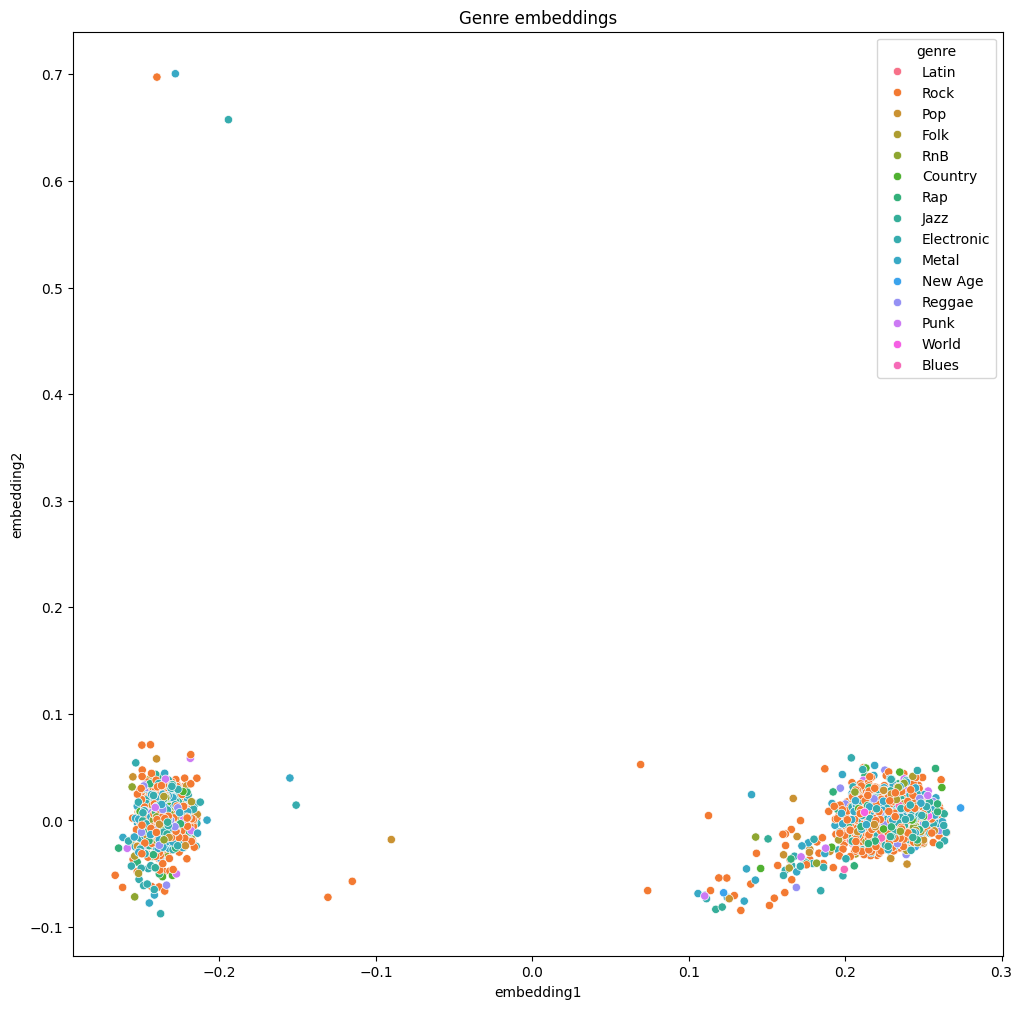

In [283]:
plot_clusters("genre")

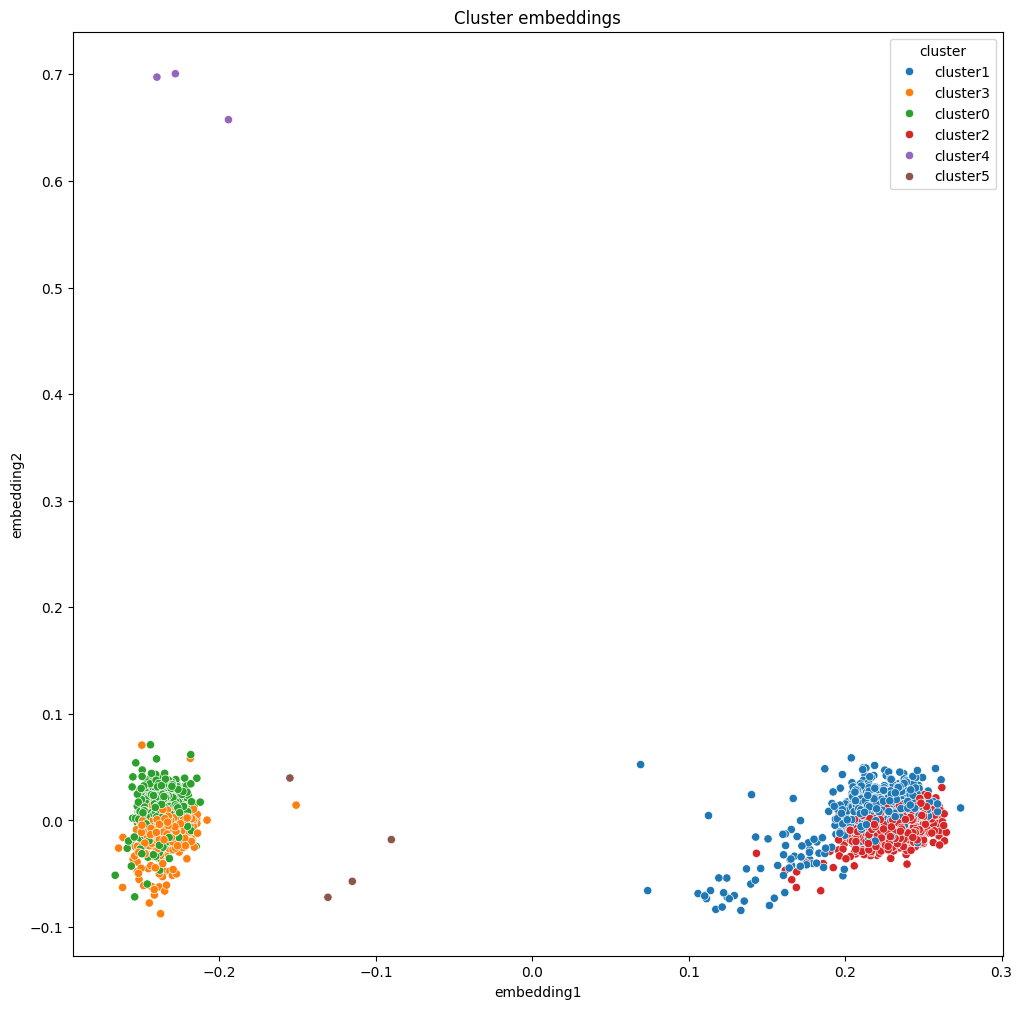

In [284]:
plot_clusters("cluster")

In [229]:
metrics.adjusted_rand_score(plot_df.genre, plot_df.cluster)

0.0013272650481271945